## Importamos las librerias ## 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

In [8]:
fees_original = pd.read_csv("../project_dataset/fees_data.csv")
fees = fees_original.copy()

# Mostrar información general del DataFrame (columnas, tipos de datos, etc.)
fees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [3]:
cash_original = pd.read_csv("../project_dataset/cash_request.csv")
cash = cash_original.copy()

# Mostrar información general sobre el DataFrame (columnas, tipos de datos, etc.)
cash.info()

# Contabilizar los valores nulos (NaN) en cada columna del DataFrame
cash.isnull().sum() 


FileNotFoundError: [Errno 2] No such file or directory: './project_dataset/cash_request.csv'

In [10]:
cash.describe()

,id,amount,user_id,deleted_account_id
count,23970.000000,23970.000000,21867.000000,2104.000000
mean,13910.966124,82.720818,32581.250789,9658.755228
std,7788.117214,26.528065,27618.565773,7972.743249
min,3.000000,1.000000,34.000000,91.000000
25%,7427.250000,50.000000,10804.000000,3767.000000
50%,14270.500000,100.000000,23773.000000,6121.500000
75%,20607.750000,100.000000,46965.000000,16345.000000
max,27010.000000,200.000000,103719.000000,30445.000000


In [11]:
# Convertir la columna 'created_at' a tipo datetime (fecha y hora) 
# El parámetro utc=True indica que el tiempo se interpretará como tiempo universal coordinado (UTC)
cash['created_at'] = pd.to_datetime(cash['created_at'], utc=True)

# Crear una nueva columna 'user_id_new' combinando los valores de 'user_id' y 'deleted_account_id'
# Se utiliza la función fillna para reemplazar los valores nulos (NaN) en 'user_id' con los valores de 'deleted_account_id'
cash['user_id_new'] = cash['user_id'].fillna(cash['deleted_account_id'])

# Mostrar información general del DataFrame (columnas, tipos de datos y número de valores no nulos)
cash.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          23970 non-null  int64              
 1   amount                      23970 non-null  float64            
 2   status                      23970 non-null  object             
 3   created_at                  23970 non-null  datetime64[ns, UTC]
 4   updated_at                  23970 non-null  object             
 5   user_id                     21867 non-null  float64            
 6   moderated_at                16035 non-null  object             
 7   deleted_account_id          2104 non-null   float64            
 8   reimbursement_date          23970 non-null  object             
 9   cash_request_received_date  16289 non-null  object             
 10  money_back_date             16543 non-null  object        

In [12]:
# Extraer año y mes de la columna 'created_at' y crear una nueva columna 'created_at_by_YM'
# Esta columna contendrá periodos de tiempo (por ejemplo, '2024-05')
cash['created_at_by_YM'] = cash['created_at'].dt.to_period('M') 

# Agrupar el DataFrame por 'user_id_new' y seleccionar la columna 'created_at_by_YM'
# Esto permite calcular la cohorte de cada usuario (mes de la primera solicitud)
grouping1 = cash.groupby('user_id_new')['created_at_by_YM']  

# Asignar a cada fila la cohorte correspondiente (mes de la primera solicitud) usando transform('min')
# El método transform aplica la función de agregación (min) dentro de cada grupo y devuelve un resultado del mismo tamaño que el DataFrame original.
cash['cohorte_month'] = grouping1.transform('min') 

# Mostrar las primeras filas del DataFrame para una vista previa de los datos
cash.head()

# Mostrar información resumida del DataFrame (columnas, tipos de datos y número de valores no nulos)
cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          23970 non-null  int64              
 1   amount                      23970 non-null  float64            
 2   status                      23970 non-null  object             
 3   created_at                  23970 non-null  datetime64[ns, UTC]
 4   updated_at                  23970 non-null  object             
 5   user_id                     21867 non-null  float64            
 6   moderated_at                16035 non-null  object             
 7   deleted_account_id          2104 non-null   float64            
 8   reimbursement_date          23970 non-null  object             
 9   cash_request_received_date  16289 non-null  object             
 10  money_back_date             16543 non-null  object        

C:\Users\Aleja\AppData\Local\Temp\ipykernel_9240\4221432086.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash['created_at_by_YM'] = cash['created_at'].dt.to_period('M')


In [13]:
cash.groupby("status").agg('count')

,id,amount,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,user_id_new,created_at_by_YM,cohorte_month
status,,,,,,,,,,,,,,,,,,
active,59,59,59,59,59,26,0,59,56,15,59,44,33,33,33,59,59,59
canceled,33,33,33,33,7,3,26,33,1,1,33,18,0,0,0,33,33,33
direct_debit_rejected,831,831,831,831,815,459,16,831,789,314,831,626,820,820,820,831,831,831
direct_debit_sent,34,34,34,34,34,15,0,34,34,4,34,31,16,16,16,34,34,34
money_back,16397,16397,16397,16397,15683,8965,715,16397,15408,16207,16397,12012,2460,2460,2460,16397,16397,16397
rejected,6568,6568,6568,6568,5221,6566,1347,6568,1,0,6568,3862,0,0,0,6568,6568,6568
transaction_declined,48,48,48,48,48,1,0,48,0,2,48,48,1,1,1,48,48,48


In [14]:
cash.groupby(cash['cohorte_month'])['amount'].count()

cohorte_month
2019-11       8
2019-12    1080
2020-01     354
2020-02     441
2020-03     371
2020-04     952
2020-05    1660
2020-06    5266
2020-07    4147
2020-08    1632
2020-09    2925
2020-10    5058
2020-11      76
Freq: M, Name: amount, dtype: int64

In [15]:
# Crear un nuevo DataFrame (crsplu) a partir de cash, seleccionando solo las columnas relevantes para el análisis:
#   - 'id': Identificador único de la transacción.
#   - 'user_id_new': Identificador del usuario (puede incluir usuarios eliminados).
#   - 'status': Estado de la transacción.
#   - 'cohorte_month': Mes en el que el usuario realizó su primera solicitud (cohorte).
#   - 'amount': Monto de la transacción.
crsplu = cash[['id','user_id_new','status','cohorte_month','amount']]

# Filtrar el DataFrame (crsplu) para incluir solo las transacciones con estado 'money_back'
# Esta línea eliminará todas las filas que no tengan 'money_back' en la columna 'status'
crsplu = crsplu[crsplu['status'].isin(['money_back'])]

# Mostrar un resumen de la información del DataFrame crsplu
# Esto incluye los nombres de las columnas, sus tipos de datos y el número de valores no nulos.
print(crsplu.info())

# Mostrar las primeras 5 filas del DataFrame crsplu 
# Esto ofrece una vista previa de cómo se ven los datos filtrados.
print(crsplu.head())


<class 'pandas.core.frame.DataFrame'>
Index: 16397 entries, 5 to 23968
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   id             16397 non-null  int64    
 1   user_id_new    16397 non-null  float64  
 2   status         16397 non-null  object   
 3   cohorte_month  16397 non-null  period[M]
 4   amount         16397 non-null  float64  
dtypes: float64(2), int64(1), object(1), period[M](1)
memory usage: 768.6+ KB
None
       id  user_id_new      status cohorte_month  amount
5    2145       9489.0  money_back       2020-05   100.0
11   1794        778.0  money_back       2019-12   100.0
13   2122       8218.0  money_back       2020-04   100.0
43   1629       9068.0  money_back       2020-05   100.0
48  23534      21465.0  money_back       2020-09    25.0


In [16]:
# Verificamos que no queden ningun nulo en el df
crsplu[crsplu['cohorte_month'].isna()]

,id,user_id_new,status,cohorte_month,amount


In [17]:
fees[fees['paid_at'].isna()].head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
9,15431,22106.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 22106,2020-10-21 08:48:50.696961+00,2020-10-21 08:48:50.696991+00,NaN,2020-11-04 22:00:00+00,2020-11-05 11:00:00+00,before
12,20199,25490.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 25490,2020-10-30 16:51:49.45659+00,2020-10-30 16:51:49.456616+00,NaN,2020-11-06 22:00:00+00,2020-11-12 11:00:00+00,before
19,19761,24564.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 24564,2020-10-29 14:00:30.956061+00,2020-10-29 14:00:30.956085+00,NaN,2020-10-29 23:00:00+00,2020-10-30 23:00:00+00,before
21,20530,19909.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 19909,2020-10-31 01:49:46.485098+00,2020-10-31 01:49:46.485121+00,NaN,2020-11-03 23:51:00+00,2020-11-05 23:00:00+00,before
29,16690,22251.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 22251,2020-10-23 19:27:18.036963+00,2020-10-23 19:27:18.036987+00,NaN,2020-10-29 11:00:00+00,2020-11-05 11:00:00+00,before


In [18]:
# Imprimir un resumen de la información del DataFrame 'fees'
# Incluye el nombre de cada columna, su tipo de datos y la cantidad de valores no nulos.
print(fees.info()) 

# Mostrar las primeras 5 filas del DataFrame 'fees'
# Esta vista previa rápida ayuda a entender la estructura de los datos.
fees.head() 

# Iterar sobre cada columna ('x') en el DataFrame 'fees'
for x in fees: 
    # Calcular y mostrar el recuento de cada valor único en la columna actual
    # Esta función de Pandas es útil para analizar la distribución de valores categóricos.
    print(fees[x].value_counts()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB
None
id
6537     1
7852     1
7846     1
7844     1
6968     1
        ..
19214    1
6206     1
20101    1
17541    1
13301    1
Name: cou

In [19]:
# Crear un nuevo DataFrame (fees_modify) a partir de fees, seleccionando solo las columnas relevantes para el análisis:
#   - 'id': Identificador único de la transacción de comisión.
#   - 'cash_request_id': Identificador de la solicitud de efectivo asociada a la comisión.
#   - 'type': Tipo de comisión.
#   - 'status': Estado de la comisión (aceptada, rechazada, etc.).
#   - 'total_amount': Monto total de la comisión.
#   - 'created_at': Fecha y hora de creación de la comisión.
#   - 'charge_moment': Momento en que se cobró la comisión.
fees_modidy = fees[['id','cash_request_id','type','status','total_amount','created_at','charge_moment']]

# Filtrar el DataFrame (fees_modify) para incluir solo las comisiones con estado 'accepted' (aceptadas)
# Esta línea eliminará todas las filas que no tengan 'accepted' en la columna 'status'
fees_accepted = fees_modidy[fees_modidy['status']== 'accepted']

# Mostrar un resumen de la información del DataFrame fees_accepted
# Esto incluye los nombres de las columnas, sus tipos de datos y el número de valores no nulos.
print(fees_accepted.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14841 entries, 1 to 21060
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               14841 non-null  int64  
 1   cash_request_id  14841 non-null  float64
 2   type             14841 non-null  object 
 3   status           14841 non-null  object 
 4   total_amount     14841 non-null  float64
 5   created_at       14841 non-null  object 
 6   charge_moment    14841 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 927.6+ KB
None


In [20]:
# Verificamos que no queden ningun nulo en el df
fees_accepted[fees_accepted['created_at'].isna()]

,id,cash_request_id,type,status,total_amount,created_at,charge_moment


In [21]:
# Crear un nuevo DataFrame (fees_modify) a partir de fees, seleccionando solo las columnas relevantes para el análisis:
#   - 'id': Identificador único de la transacción de comisión.
#   - 'cash_request_id': Identificador de la solicitud de efectivo asociada a la comisión.
#   - 'type': Tipo de comisión.
#   - 'status': Estado de la comisión (aceptada, rechazada, etc.).
#   - 'total_amount': Monto total de la comisión.
#   - 'created_at': Fecha y hora de creación de la comisión.
#   - 'charge_moment': Momento en que se cobró la comisión.
fees_modidy = fees[['id','cash_request_id','type','status','total_amount','created_at','charge_moment']]

# Filtrar el DataFrame (fees_modify) para incluir solo las comisiones con estado 'accepted' (aceptadas)
# Esta línea eliminará todas las filas que no tengan 'accepted' en la columna 'status'
fees_accepted = fees_modidy[fees_modidy['status']== 'accepted']

# Convertir la columna 'created_at' en el DataFrame de tarifas aceptadas (fees_accepted) al tipo de dato datetime
# El argumento `utc=True` asegura que los valores de fecha y hora se interpreten como Tiempo Universal Coordinado (UTC)
# Esto es importante para la consistencia de las fechas y horas cuando los datos pueden provenir de diferentes zonas horarias.
fees_accepted['created_at'] = pd.to_datetime(fees_accepted['created_at'], utc=True)

# Extraer año y mes de la columna 'created_at' y crear una nueva columna 'created_at_fees_by_YM'
# Esta nueva columna almacena un período de tiempo que representa el año y el mes en que se creó la comisión.
# Por ejemplo, '2024-05' representaría el mes de mayo de 2024.
fees_accepted['created_at_fees_by_YM'] = fees_accepted['created_at'].dt.to_period('M') 

# Agrupar el DataFrame 'fees_accepted' por 'cash_request_id' y selecciona la columna 'created_at_fees_by_YM'
# Esto permite calcular la cohorte de cada comisión (mes de la primera comisión aceptada relacionada con una solicitud de efectivo)
grouping1 = fees_accepted.groupby('cash_request_id')['created_at_fees_by_YM'] 

# Agregar una nueva columna 'cohorte_month_fees' al DataFrame fees_accepted
# Esta columna contiene, para cada comisión, el valor del primer mes (cohorte) en el que se aceptó una comisión relacionada con la misma solicitud de efectivo
# Se logra esto mediante la función `transform('min')`, que calcula el valor mínimo de 'created_at_fees_by_YM' dentro de cada grupo de 'cash_request_id'
# y luego llena el DataFrame original con ese valor mínimo para cada fila.
fees_accepted['cohorte_month_fees'] = fees_accepted.groupby('cash_request_id')['created_at_fees_by_YM'].transform('min')  

# Imprimir información resumida sobre el DataFrame fees_accepted
# Esto incluye los nombres de las columnas, sus tipos de datos y el número de valores no nulos.
print(fees_accepted.info())


<class 'pandas.core.frame.DataFrame'>
Index: 14841 entries, 1 to 21060
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     14841 non-null  int64              
 1   cash_request_id        14841 non-null  float64            
 2   type                   14841 non-null  object             
 3   status                 14841 non-null  object             
 4   total_amount           14841 non-null  float64            
 5   created_at             14841 non-null  datetime64[ns, UTC]
 6   charge_moment          14841 non-null  object             
 7   created_at_fees_by_YM  14841 non-null  period[M]          
 8   cohorte_month_fees     14841 non-null  period[M]          
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(3), period[M](2)
memory usage: 1.1+ MB
None


C:\Users\Aleja\AppData\Local\Temp\ipykernel_9240\858010427.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fees_accepted['created_at'] = pd.to_datetime(fees_accepted['created_at'], utc=True)
C:\Users\Aleja\AppData\Local\Temp\ipykernel_9240\858010427.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fees_accepted['created_at_fees_by_YM'] = fees_accepted['created_at'].dt.to_period('M')
C:\Users\Aleja\AppData\Local\Temp\ipykernel_9240\858010427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [22]:
print(crsplu.info())
print(fees_accepted.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16397 entries, 5 to 23968
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   id             16397 non-null  int64    
 1   user_id_new    16397 non-null  float64  
 2   status         16397 non-null  object   
 3   cohorte_month  16397 non-null  period[M]
 4   amount         16397 non-null  float64  
dtypes: float64(2), int64(1), object(1), period[M](1)
memory usage: 768.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 14841 entries, 1 to 21060
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     14841 non-null  int64              
 1   cash_request_id        14841 non-null  float64            
 2   type                   14841 non-null  object             
 3   status                 14841 non-null  object             
 4   

In [23]:
# Combinar dos DataFrames (crsplu y fees_accepted) en uno solo llamado merge_fees_cash
# - Se usa un 'right join' para incluir todas las filas de fees_accepted y solo las filas coincidentes de crsplu.
# - La coincidencia se realiza utilizando 'cash_request_id' en fees_accepted y 'id' en crsplu como claves de unión.
merge_fees_cash =  crsplu.merge(fees_accepted, right_on='cash_request_id', left_on='id', how='right')

# Mostrar las primeras filas del DataFrame resultante 'merge_fees_cash' para verificar la unión
merge_fees_cash


,id_x,user_id_new,status_x,cohorte_month,amount,id_y,cash_request_id,type,status_y,total_amount,created_at,charge_moment,created_at_fees_by_YM,cohorte_month_fees
0,11714.0,16158.0,money_back,2020-06,100.0,6961,11714.0,incident,accepted,5.0,2020-09-09 20:51:17.998653+00:00,after,2020-09,2020-08
1,23371.0,81575.0,money_back,2020-10,100.0,16296,23371.0,instant_payment,accepted,5.0,2020-10-23 10:10:58.352972+00:00,after,2020-10,2020-10
2,26772.0,94393.0,money_back,2020-10,100.0,20775,26772.0,instant_payment,accepted,5.0,2020-10-31 15:46:53.643958+00:00,after,2020-10,2020-10
3,19350.0,19005.0,money_back,2020-06,50.0,11242,19350.0,instant_payment,accepted,5.0,2020-10-06 08:20:17.170432+00:00,after,2020-10,2020-10
4,24052.0,90386.0,money_back,2020-10,100.0,17029,24052.0,instant_payment,accepted,5.0,2020-10-24 12:22:27.666102+00:00,after,2020-10,2020-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14836,20616.0,13681.0,money_back,2020-06,100.0,12867,20616.0,instant_payment,accepted,5.0,2020-10-12 13:54:28.690344+00:00,after,2020-10,2020-10
14837,17921.0,48391.0,money_back,2020-09,50.0,15712,17921.0,incident,accepted,5.0,2020-10-21 22:22:56.192830+00:00,after,2020-10,2020-09
14838,15088.0,17553.0,money_back,2020-06,100.0,14209,15088.0,incident,accepted,5.0,2020-10-16 23:49:42.047800+00:00,after,2020-10,2020-09
14839,12520.0,23912.0,money_back,2020-07,100.0,18244,12520.0,incident,accepted,5.0,2020-10-27 00:16:30.736241+00:00,after,2020-10,2020-08


In [24]:
# Eliminar filas donde la columna 'id_x' contenga valores nulos (NaN), directamente en el DataFrame original 
# El argumento inplace=True modifica directamente el DataFrame merge_fees_cash en lugar de crear una copia.
merge_fees_cash.dropna(subset=['id_x'], inplace=True)

# Mostrar un resumen de la información del DataFrame 'merge_fees_cash' 
# (nombres de columnas, tipos de datos, y cantidad de valores no nulos por columna)
merge_fees_cash.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14469 entries, 0 to 14839
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id_x                   14469 non-null  float64            
 1   user_id_new            14469 non-null  float64            
 2   status_x               14469 non-null  object             
 3   cohorte_month          14469 non-null  period[M]          
 4   amount                 14469 non-null  float64            
 5   id_y                   14469 non-null  int64              
 6   cash_request_id        14469 non-null  float64            
 7   type                   14469 non-null  object             
 8   status_y               14469 non-null  object             
 9   total_amount           14469 non-null  float64            
 10  created_at             14469 non-null  datetime64[ns, UTC]
 11  charge_moment          14469 non-null  object             


In [25]:
for x in merge_fees_cash:
  print(merge_fees_cash[x].value_counts())

id_x
3759.0     13
12452.0     5
1655.0      5
8948.0      5
5006.0      5
           ..
21484.0     1
24603.0     1
26030.0     1
23193.0     1
20616.0     1
Name: count, Length: 11588, dtype: int64
user_id_new
17144.0    15
12934.0    11
18984.0     8
13404.0     7
5189.0      7
           ..
37283.0     1
78193.0     1
83737.0     1
77972.0     1
85044.0     1
Name: count, Length: 8343, dtype: int64
status_x
money_back    14469
Name: count, dtype: int64
cohorte_month
2020-10    4643
2020-06    2774
2020-09    2237
2020-07    2139
2020-08     985
2020-05     756
2020-04     305
2019-12     220
2020-02     127
2020-03     122
2020-01      91
2020-11      64
2019-11       6
Freq: M, Name: count, dtype: int64
amount
100.0    9414
50.0     3297
25.0     1091
80.0      117
60.0      110
20.0       91
70.0       87
30.0       68
40.0       52
90.0       38
10.0       36
95.0        9
35.0        7
15.0        7
45.0        7
55.0        7
65.0        5
5.0         5
75.0        4
200.0    

In [26]:

# Agrupar por cohorte y sumar los ingresos totales de cada cohorte
cohort_ingresos = merge_fees_cash.groupby('cohorte_month')['total_amount'].sum().reset_index()

# Renombrar las columnas del DataFrame resultante
cohort_ingresos.columns = ['cohorte_month', 'Ingresos por cohorte']

# Imprimir los ingresos generados por cada cohorte
print('Estos son los ingresos generados por mes\n', cohort_ingresos)

# Imprimir el total de ingresos de todas las cohortes
print('\nTotal de ingresos es de ', merge_fees_cash['total_amount'].sum())

Estos son los ingresos generados por mes
    cohorte_month  Ingresos por cohorte
0        2019-11                  30.0
1        2019-12                1100.0
2        2020-01                 455.0
3        2020-02                 635.0
4        2020-03                 610.0
5        2020-04                1525.0
6        2020-05                3780.0
7        2020-06               13870.0
8        2020-07               10695.0
9        2020-08                4925.0
10       2020-09               11185.0
11       2020-10               23220.0
12       2020-11                 320.0

Total de ingresos es de  72350.0


## Gráficos ##

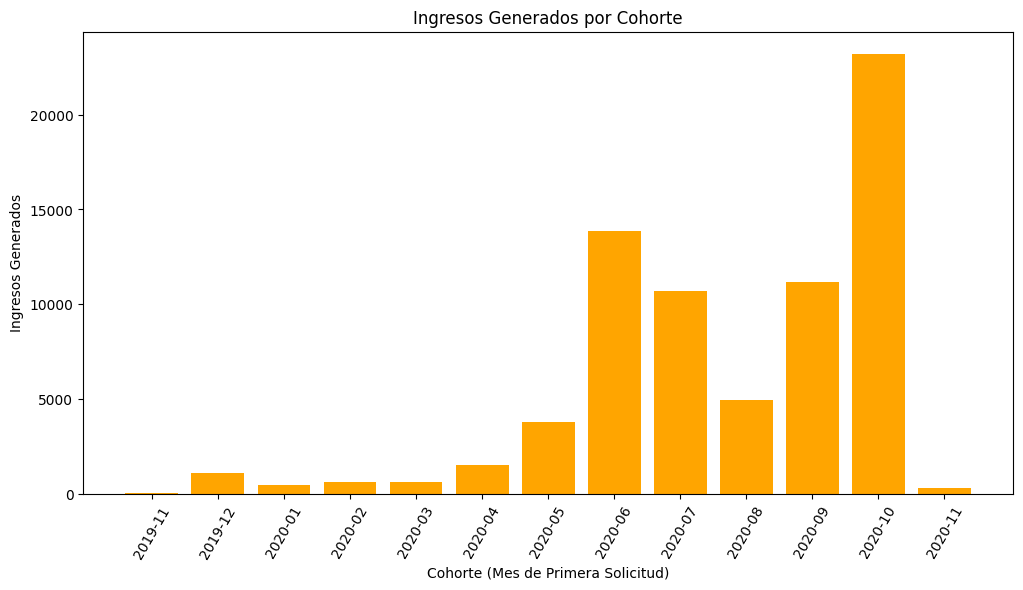

In [27]:
# Crear un gráfico de barras para visualizar los ingresos por cohorte
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura (12 pulgadas de ancho, 6 de alto)

# Crear las barras del gráfico
#   - Eje X: Los meses de las cohortes (convertidos a cadenas de texto para mostrarlos correctamente)
#   - Eje Y: Los ingresos generados por cada cohorte
#   - color='skyblue': Color de las barras (puedes cambiarlo a tu gusto)
plt.bar(cohort_ingresos['cohorte_month'].astype(str), cohort_ingresos['Ingresos por cohorte'], color='orange')

# Añadir etiquetas a los ejes X e Y
plt.xlabel('Cohorte (Mes de Primera Solicitud)')
plt.ylabel('Ingresos Generados')

# Añadir un título al gráfico
plt.title('Ingresos Generados por Cohorte')

# Rotar las etiquetas del eje X para mejorar la legibilidad
plt.xticks(rotation=60)  # Ángulo de rotación de 60 grados

# Mostrar el gráfico
plt.show()


In [28]:
#merge_fees_cash['month'] = merge_fees_cash['created_at'].dt.to_period('M')

# Agrupar por cohorte y mes para sumar los ingresos
ingreso_mensual_por_cohorte= merge_fees_cash.groupby(['cohorte_month', 'created_at_fees_by_YM'])['total_amount'].sum().reset_index()

# Pivotear los datos para el mapa de calor
pivot_income = ingreso_mensual_por_cohorte.pivot(index='cohorte_month', columns='created_at_fees_by_YM', values='total_amount')
pivot_income

created_at_fees_by_YM,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
cohorte_month,,,,,,,
2019-11,NaN,NaN,5.0,5.0,10.0,10.0,NaN
2019-12,NaN,60.0,125.0,280.0,285.0,350.0,NaN
2020-01,NaN,25.0,65.0,115.0,100.0,150.0,NaN
2020-02,NaN,55.0,45.0,175.0,145.0,210.0,5.0
2020-03,NaN,50.0,75.0,130.0,170.0,180.0,5.0
2020-04,15.0,110.0,210.0,370.0,400.0,415.0,5.0
2020-05,40.0,300.0,520.0,950.0,940.0,1000.0,30.0
2020-06,NaN,1030.0,1685.0,3695.0,3490.0,3915.0,55.0
2020-07,NaN,NaN,1040.0,3155.0,3040.0,3435.0,25.0


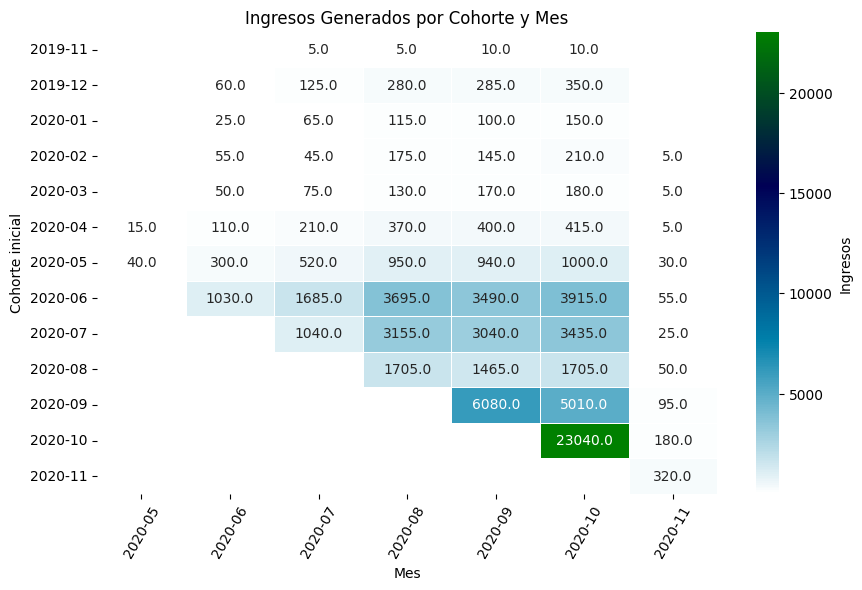

In [29]:
# Crear una figura para el gráfico
plt.figure(figsize=(10, 6)) # Ajusta el tamaño de la figura (10 pulgadas de ancho, 6 de alto)

# Crear el mapa de calor usando la biblioteca Seaborn (sns)
sns.heatmap(
    pivot_income,          # DataFrame con los ingresos por cohorte y mes, pivot table 
    cmap='ocean_r',       # Elegir una paleta de color que se adapte a los datos
    fmt=".1f",            # Mostrar los valores de la matriz con un decimal
    cbar_kws={'label': 'Ingresos'},  # Etiqueta de la barra de color del gráfico 
    annot=True,           # Mostrar los valores en cada celda del mapa de calor
    linewidths=0.5        # Agregar líneas blancas entre las celdas para mejor legibilidad 
)

# Añadir un título al gráfico
plt.title('Ingresos Generados por Cohorte y Mes')

# Etiquetas para los ejes X e Y
plt.xlabel('Mes')
plt.ylabel('Cohorte inicial')

# Ajustar la rotación de las etiquetas del eje X para que se puedan leer
plt.xticks(rotation=60)

# Mostrar el gráfico
plt.show()
